In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supplementary-rewritten-texts/gemma_suppl_rewrite.csv


In [2]:
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
import keras 
import tensorflow

2024-04-03 04:32:59.460300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 04:32:59.460504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 04:32:59.637809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load CSV data
filename = '/kaggle/input/supplementary-rewritten-texts/gemma_suppl_rewrite.csv'
data = pd.read_csv(filename)

In [4]:
data.head(10)

,id,original_text,rewrite_prompts,rewritten_text
0,0,Memo\n\nTo: All Staff\nFrom: Keith\nSubject: F...,Reimagine the fish tank maintenance task as a ...,"Sure, here's the rewritten text:\n\nTo: All St..."
1,1,Hey Suzann! Just wanted to let you know that G...,"Rewrite the text in a more formal tone, emphas...","Sure, here's the rewritten text:\n\n""It would ..."
2,2,"Amy plucked the strings of her zither, filling...","Rewrite the text in a more concise manner, pre...","Sure, here's the rewritten text:\n\nThe zither..."
3,3,"Betty's peony bloomed beautifully, filling her...",Rewrite the text in a more concise and impactf...,"The peony bloomed radiantly, casting vibrant h..."
4,4,"The cornet, a brass instrument similar to a tr...","Rewrite the text in a more concise manner, foc...","The cornet, a brass instrument like a trumpet,..."
5,5,"Ladies and gentlemen, dysfunction is a word th...","Rewrite the text in a more formal tone, preser...","Ladies and gentlemen, the evocative term ""dysf..."
6,6,The ovary is an essential part of the female r...,"Describe the ovary in vivid detail, using sens...","The ovary pulsed with a symphony of secrets, a..."
7,7,"Jane and her friends set sail on their yawl, t...",Describe the initial encounter with the cove i...,The turquoise waters stretched out before Jane...
8,8,"Today, Angela and I explored the world of gast...","Describe the food festival in vivid detail, in...","The aromas of fresh herbs, sizzling meat, and ..."
9,9,Title: The Bronco: A Classic American Icon\n\n...,Rewrite the text to emphasize the historical s...,"Sure, here's the rewritten text:\n\nThe Bronco..."


In [5]:
data.tail(10)

,id,original_text,rewrite_prompts,rewritten_text
290,290,Hey Marie! Just wanted to let you know that I ...,"Rewrite the text in a more formal tone, preser...","""Dear Marie,""\n\nI hope this email finds you w..."
291,291,"Journal Entry - Naturalisation\n\nToday, I att...",Expand on the role of the mayor's speech and i...,The mayor's speech played a pivotal role in th...
292,292,Steven and his friends decided to go on a camp...,"Describe the camping trip in vivid detail, foc...",The wagon roared with the force of a hurricane...
293,293,Report: A recent survey found that 75% of resp...,Rewrite the sentence in a more concise and eng...,"Sure, here's the rewritten text:\n\nA recent s..."
294,294,Report: Smoke was detected at the construction...,Rewrite the sentence about no injuries in a mo...,No injuries were reported at the construction ...
295,295,"Dear Dr. Smith, \n\nI hope this letter finds y...","Rewrite the text in a more formal tone, emphas...","Dear Dr. Smith,\n\nI trust this letter finds y..."
296,296,Memo\n\nTo: All Employees\nFrom: Vincent\nDate...,Rewrite the text to emphasize the negative imp...,"Sure, here's the rewritten text:\n\nMemo\n\nTo..."
297,297,"Nathan, a renowned historian, uncovered a hidd...",Rewrite the text in a way that emphasizes the ...,"The breadfruit's aroma permeated the air, a te..."
298,298,"David, a passionate baker, carefully placed hi...",Describe the process of placing and waiting fo...,"David, a passionate baker, meticulously placed..."
299,299,"Etta tuned her shortwave radio, eagerly awaiti...","Rewrite the text in a more formal tone, preser...","Sure, here's the rewritten text:\n\nEtta metic..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               300 non-null    int64 
 1   original_text    300 non-null    object
 2   rewrite_prompts  300 non-null    object
 3   rewritten_text   300 non-null    object
dtypes: int64(1), object(3)
memory usage: 9.5+ KB


In [7]:
data.columns

Index(['id', 'original_text', 'rewrite_prompts', 'rewritten_text'], dtype='object')

In [8]:
# Tokenization and Lowercasing with NLTK
tokens = [word_tokenize(text.lower()) for text in data['original_text']]

In [10]:
# TF-IDF Vectorization

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['original_text'])

In [11]:
# Word2Vec Model
word2vec_model = Word2Vec(tokens, min_count=1)

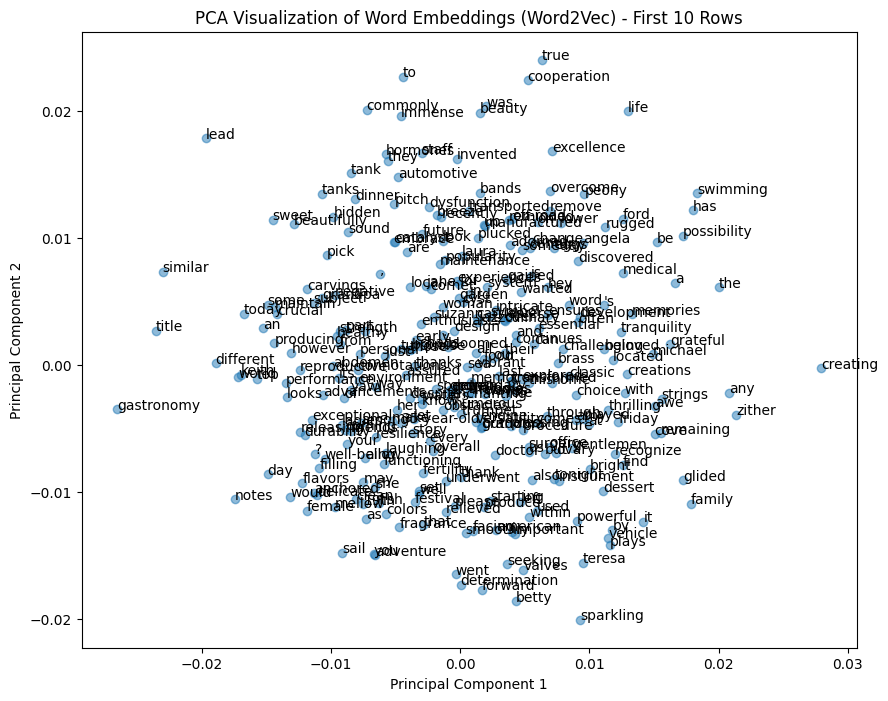

In [16]:
# Subset the first 10 rows of the data
subset_data = data.head(10)

# Tokenization and Lowercasing with NLTK for the subset
subset_tokens = [word_tokenize(text.lower()) for text in subset_data['original_text']]

# Word2Vec Model for the subset
subset_word2vec_model = Word2Vec(subset_tokens, min_count=1)

# Visualizing Word Embeddings with PCA for the subset
X_word2vec_subset = subset_word2vec_model.wv[subset_word2vec_model.wv.key_to_index]
pca = PCA(n_components=2)
result_word2vec_subset = pca.fit_transform(X_word2vec_subset)

plt.figure(figsize=(10, 8))
plt.scatter(result_word2vec_subset[:, 0], result_word2vec_subset[:, 1], alpha=0.5)
subset_words = list(subset_word2vec_model.wv.index_to_key)
for i, word in enumerate(subset_words):
    plt.annotate(word, xy=(result_word2vec_subset[i, 0], result_word2vec_subset[i, 1]))
plt.title('PCA Visualization of Word Embeddings (Word2Vec) - First 10 Rows')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [45]:
import pandas as pd

# Example DataFrame
data = pd.read_csv('/kaggle/input/supplementary-rewritten-texts/gemma_suppl_rewrite.csv')

df = data

def summarize_mode(column):
    return column.mode().iloc[0]

df['mode_summary'] = summarize_mode(df['id']) 
print(df)

      id                                      original_text  \
0      0  Memo\n\nTo: All Staff\nFrom: Keith\nSubject: F...   
1      1  Hey Suzann! Just wanted to let you know that G...   
2      2  Amy plucked the strings of her zither, filling...   
3      3  Betty's peony bloomed beautifully, filling her...   
4      4  The cornet, a brass instrument similar to a tr...   
..   ...                                                ...   
295  295  Dear Dr. Smith, \n\nI hope this letter finds y...   
296  296  Memo\n\nTo: All Employees\nFrom: Vincent\nDate...   
297  297  Nathan, a renowned historian, uncovered a hidd...   
298  298  David, a passionate baker, carefully placed hi...   
299  299  Etta tuned her shortwave radio, eagerly awaiti...   

                                       rewrite_prompts  \
0    Reimagine the fish tank maintenance task as a ...   
1    Rewrite the text in a more formal tone, emphas...   
2    Rewrite the text in a more concise manner, pre...   
3    Rewrit

In [58]:
import pandas as pd
import nltk 
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# Load CSV data
filename = '/kaggle/input/supplementary-rewritten-texts/gemma_suppl_rewrite.csv'  
data = pd.read_csv(filename)

# Preprocess text (using NLTK for word tokenization)
data['tokenized_text'] = data['original_text'].apply(word_tokenize)

# Create vocabulary and sequences
tokenizer = nltk.FreqDist()  # Simpler for demonstration 
for text in data['tokenized_text']:
    tokenizer.update(text)

word_index = {word: idx + 1 for idx, (word, _) in enumerate(tokenizer.most_common())}

def text_to_sequence(text, word_index):
    return [word_index.get(word, 0) for word in text]  # 0 for unknown words

sequences = data['tokenized_text'].apply(lambda x: text_to_sequence(x, word_index))

# Pad sequences
max_length = 100 
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [65]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['target'] = le.fit_transform(data['original_text']) 

# Define problem
vocab_size = len(tokenizer.most_common()) + 1 
max_length = 100

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=8, input_shape=(max_length,)))  # Input shape added
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(padded_sequences, data['target'], epochs=10, batch_size=32, validation_split=0.2) 

# Summarize the model
print(model.summary())

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0014 - loss: -7.3269 - val_accuracy: 0.0000e+00 - val_loss: -33.3789
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0014 - loss: -51.1512 - val_accuracy: 0.0000e+00 - val_loss: -98.0819
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0047 - loss: -131.5102 - val_accuracy: 0.0000e+00 - val_loss: -229.5630
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0014 - loss: -310.2531 - val_accuracy: 0.0000e+00 - val_loss: -481.5104
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0020 - loss: -612.8015 - val_accuracy: 0.0000e+00 - val_loss: -911.7719
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0065 - loss: -1126.4880 - val_accuracy: 0.0000e+00 - val_loss: -1589.1998
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0099 - loss: -1800.0092 - val_accuracy: 0.0000e+00 - val_loss: -2584.0562
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0020 - loss

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ (None, 100, 8)         │        32,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,165 (395.18 KB)

 Trainable params: 33,721 (131.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,444 (263.46 KB)

None
